In [5]:
import numpy as np
import os
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
np.random.seed(0)

def create_df(drop_pano = True, path = "Places_Data/train_val"):
    """
    Creates Dataframe consisting of all images of the train_val part of the Mapilarly Places Dataset
    drop_pano - Wether to trop pano images
    """

    CSVs = []

    for city in os.listdir("../"+path):
        j = []
        for folder in ['query', 'database']:

            # read csvs
            path = f"{path}/{city}/{folder}"
            csv = pd.read_csv(f"../{path}/postprocessed.csv",index_col = 1)
            raw = pd.read_csv(f"../{path}/raw.csv",index_col = 1)
            seq = pd.read_csv(f"../{path}/seq_info.csv",index_col = 1)
            csv = csv.merge(raw["pano"].to_frame(),left_index=True,right_index=True).merge(seq,left_index=True,right_index=True)
            csv["Path"] = path
            csv["City"] = city
            csv = csv.reset_index()
            j.append(csv)

        csv = pd.concat(j)

        # Directly throw aways images with a differennce in view_direction in a single sequence
        change = csv.groupby("sequence_key")["view_direction"].unique().apply(lambda x : len(x)>1)
        change = change[change==1].index
        drop = csv["sequence_key"].apply(lambda x: x not in change)
        csv = csv.loc[drop] # drop
        csv.set_index("key",inplace=True)
        CSVs.append(csv)
        print(city)

    df = pd.concat(CSVs)
    if drop_pano:
        df = df.loc[df["pano"]==False]
    df.drop(columns=["pano","Unnamed: 0_y","Unnamed: 0_x"],inplace=True)
    df.reset_index().to_feather("prelim.feather")

    return df

In [8]:
df = pd.read_feather("prelim.feather").set_index("key")
df.head()

,easting,northing,unique_cluster,control_panel,night,view_direction,sequence_key,frame_number,Path,City
key,,,,,,,,,,
Ek08yvVCR1tXrD4ZSx59CA,386194.912199,5.813341e+06,0,False,False,Forward,b_na8Od36yIQHjiIRkfw9g,28,Places_Data/train_val/berlin/query,berlin
aCucEyYErknYIk99tYLHiQ,386199.044656,5.813348e+06,0,False,False,Forward,b_na8Od36yIQHjiIRkfw9g,29,Places_Data/train_val/berlin/query,berlin
nYhcqj88tExjKqYf0nrO3g,386204.488335,5.813355e+06,0,False,False,Forward,b_na8Od36yIQHjiIRkfw9g,30,Places_Data/train_val/berlin/query,berlin
eLqnEy7NZAuP6WbRzLJm7g,386209.148824,5.813360e+06,0,False,False,Forward,b_na8Od36yIQHjiIRkfw9g,31,Places_Data/train_val/berlin/query,berlin
lZqqhLInfkKV0EJlrbSH_w,386214.585088,5.813366e+06,0,True,False,Forward,b_na8Od36yIQHjiIRkfw9g,32,Places_Data/train_val/berlin/query,berlin


Assert that there is now change in view direction in a sequence. This is an effort to clean the data

In [9]:
assert df.groupby("sequence_key")["view_direction"].unique().apply(lambda x : len(x)>1).sum() == 0

In [12]:
def return_cluster_distances(df):
    """
    measures distances inside clusters between following images
    """


    vals = df.reset_index().groupby(["sequence_key","unique_cluster"])[["easting","northing","frame_number","view_direction","key"]]
    
    distances = {}
    for i in tqdm.tqdm(vals):

        # sort by framenumber to get follwing images next to each other
        val_df = i[1].sort_values("frame_number")

        # if cluster has more then one image, measure the distances
        list_of_values = [np.linalg.norm(val_df.iloc[1:,:2].values-val_df.iloc[:-1,:2].values,axis=1) if len(val_df)>1 else np.nan]
        # get additional values
        list_of_values.extend([val_df.loc[:,"easting"].values,val_df.loc[:,"northing"].values,val_df.loc[:,"frame_number"].values,val_df.loc[:,"view_direction"].iloc[0],val_df.loc[:,"key"].values])

        distances[i[0]] = list_of_values

    # create dataframe
    distances_df = pd.DataFrame.from_dict(distances,orient="index",columns=["distances","eastings","northings","frame_numbers","view_direction","keys"])
    distances_df.index= pd.MultiIndex.from_tuples(distances.keys(),names=["seq_key","unique_cluster"])
    # makesure no loss of data
    assert len(vals)==len(distances_df)

    return distances_df

distances = return_cluster_distances(df)
# drop seqs with only one image
distances = distances[distances.distances.notna()]
distances.reset_index().to_feather("distances.feather")

100%|██████████| 58490/58490 [01:27<00:00, 670.71it/s]


In [13]:
distances = pd.read_feather("distances.feather")
distances.head()

,seq_key,unique_cluster,distances,eastings,northings,frame_numbers,view_direction,keys
0,--_eoC7UTouajlxFGe_GXA,2335,"[1.9991689570222801, 1.9991690497322785, 1.997...","[348609.62254308583, 348611.58653987874, 34861...","[5264955.418967944, 5264955.045614068, 5264954...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Forward,"[Obu51NKsZNM3h8lqD6_4mg, Yi057MRqZ7T7y13WkXJiu..."
1,--eu3bHFTUCKSLapTL7MOg,1865,"[13.194837425679545, 14.034609679521436, 12.46...","[360506.1986491318, 360496.3414777967, 360483....","[5265351.270328949, 5265342.498789292, 5265337...","[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20...",Forward,"[y6o6tsGiOef_Cf4FVPp9Qg, L5h7xgbIfSGHMOA9V8LBh..."
2,--eu3bHFTUCKSLapTL7MOg,1869,"[11.272819395079715, 10.71167950464816, 10.882...","[360585.0232870288, 360575.6552866981, 360566....","[5265409.3793450985, 5265403.109016007, 526539...","[1, 2, 3, 4, 5]",Forward,"[B3UUFLa5gODvxzgouP7HcA, ZG7Jp1Gl47v7RBmwulh4Y..."
3,--eu3bHFTUCKSLapTL7MOg,1916,"[10.260274201799714, 9.624044058255096, 8.9267...","[360926.18905079865, 360918.24529940897, 36091...","[5264006.718574269, 5264000.224727908, 5263994...","[198, 199, 200, 201, 202]",Forward,"[sQZUAvsVHo5xZZqjXSXK2w, diUa4yV8_uyvmNFisiPFM..."
4,--eu3bHFTUCKSLapTL7MOg,1957,"[13.71390689075564, 14.565140723861626, 9.9573...","[361016.87347187696, 361024.43116971385, 36103...","[5262105.691495253, 5262094.248049722, 5262082...","[411, 412, 413, 414, 415, 416, 417, 418, 419, ...",Forward,"[oTYHziGNW5fAgbpAaP8R1g, Uc7rzTzBXF82E9aGIOWqV..."


Plot Density Plot of Densities to next images

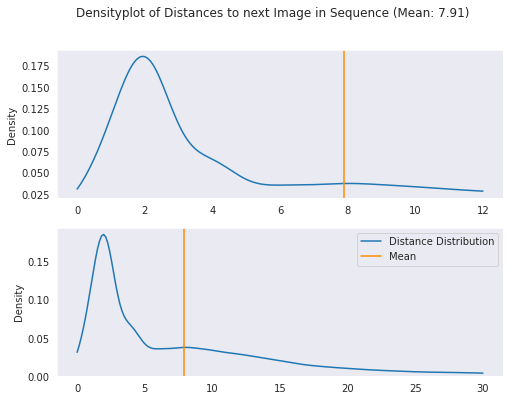

In [14]:
all_distances = np.concatenate(distances["distances"].dropna().values)
fig = plt.figure(figsize=(8,6))
fig.add_subplot(211)
sns.kdeplot(all_distances,clip=[0,12])
plt.axvline(x=all_distances.mean(),color="darkorange",label='Mean')
fig.add_subplot(212)
sns.kdeplot(all_distances,clip=[0,30],label="Distance Distribution")
plt.axvline(x=all_distances.mean(),color="darkorange",label='Mean')
plt.legend()
plt.suptitle(f"Densityplot of Distances to next Image in Sequence (Mean: {all_distances.mean():.2f})")
plt.show()

In [15]:
def get_splits(arr,max_distnace):
    """
    This functions returns the point where to split a sequnce if it has to distances above the max distance
    """
    # get the positions
    pos = np.argwhere(arr > max_distnace).reshape(-1)
    start = 0

    if pos[0]==0: # if value is at start
        start = 1 # we drop the first pos
        pos = pos[1:]

    splits = []
    for val in pos: # for all the rest

        if start != val: # if there was not a split right before

            if start+1 != val:
                splits.append((start,val+1)) # append next val


        start = val +1 # set start further

    if start < len(arr)-1: # if still somethings left
        splits.append((start,len(arr))) # add the rest
        
    return splits

def split(arr,splits):
    """
    This simply returns the the splitted arrays in a list"""
    return [arr[front:back] for front,back in splits]

def get_distance(i):
    return np.linalg.norm(i[1:]-i[:-1],axis=1)

def cut_distances(distances, max_distance):
    """
    This function cuts sequences of a dataframe in to smaller ones that dont have a max distance between neighboring images above the specified argument
    """
    # get cluster labels to use later for keeping unambiguous cluster ids later
    cluster_labels = distances.groupby("seq_key")["unique_cluster"].max()

    # get seqs we have to split
    distances["max"] = distances["distances"].apply(np.max)
    to_split = distances[distances["max"] > max_distance].copy()

    # create cords column
    coords = []
    for i in to_split.loc[:,["eastings","northings"]].values:
        coords.append(np.concatenate([b.reshape(-1,1)for b in i],axis=1))
    to_split["cords"] = coords


    rows = []; indeces = []

    for index in tqdm.tqdm(to_split.index):
        # get the sequence
        arr = to_split.loc[index]

        # iterate over the splits
        for i,split in enumerate(get_splits(arr["distances"],max_distance)):
            
            # create an empty row
            row = pd.Series(dtype="object")

            if split[0]+1!= split[1]:
                
                #add the splitted arrays
                for column in ['eastings', 'northings','frame_numbers','keys', 'cords']:

                    row[column] = arr[column][split[0]:split[1]]

                # to check the ensure the correctness of this aproach recheck the max distance 
                row["distances"] = get_distance(row["cords"])
                row["max"] = row["distances"].max()
                assert row["distances"].max() <= max_distance, "Error"

                # add further rows
                row["view_direction"], row["seq_key"], row["old_unique_cluster"] = arr["view_direction"], arr["seq_key"],arr["unique_cluster"]
                # increase cluster label and assign new unanbigious one
                cluster_labels.loc[arr["seq_key"]] += 1
                row["new_unique_cluster"] = cluster_labels.loc[arr["seq_key"]]

                # append indeces
                indeces.append((row["seq_key"],row["new_unique_cluster"]))
                rows.append(row)

    new = pd.DataFrame(rows,index= pd.MultiIndex.from_tuples(indeces)).append(distances[distances["max"] <= max_distance].set_index(["seq_key","unique_cluster"]))

    new["max"] = new["distances"].apply(np.max)

    return new

In [16]:
max_50 = cut_distances(distances,50)
max_50 = max_50.reset_index()

100%|██████████| 2127/2127 [00:33<00:00, 63.73it/s]
/tmp/ipykernel_162015/96439906.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new = pd.DataFrame(rows,index= pd.MultiIndex.from_tuples(indeces)).append(distances[distances["max"] <= max_distance].set_index(["seq_key","unique_cluster"]))


Creating Dataframe for training

In [17]:
# Add Info for the seqs we did not have to split
max_50.loc[max_50.cords.isna(), "seq_key"] = max_50.loc[max_50.cords.isna(), "level_0"]
cluster_ids = max_50.loc[max_50.cords.isna(), "level_1"]
max_50.loc[max_50.cords.isna(), "old_unique_cluster"] = cluster_ids
max_50.loc[max_50.cords.isna(), "new_unique_cluster"] = cluster_ids
max_50 = max_50.astype({"old_unique_cluster":int, "new_unique_cluster":int}).drop(columns=["level_1","level_0","cords"])
max_50.to_feather(f"max_distance_of_{50}.feather")

From here on there are Visualisations to choose the specifics of our experiment

In [18]:
for_plot = {}
for max_distance in [20,25,30,35,40,45,50,55]:
    print("Now Calcutlating",max_distance)
    for_plot[max_distance] = cut_distances(distances,max_distance).reset_index().drop(columns="cords")

Now Calcutlating 20


100%|██████████| 21420/21420 [03:46<00:00, 94.49it/s] 
/tmp/ipykernel_162015/96439906.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new = pd.DataFrame(rows,index= pd.MultiIndex.from_tuples(indeces)).append(distances[distances["max"] <= max_distance].set_index(["seq_key","unique_cluster"]))


Now Calcutlating 25


100%|██████████| 15899/15899 [02:11<00:00, 120.84it/s]
/tmp/ipykernel_162015/96439906.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new = pd.DataFrame(rows,index= pd.MultiIndex.from_tuples(indeces)).append(distances[distances["max"] <= max_distance].set_index(["seq_key","unique_cluster"]))


Now Calcutlating 30


100%|██████████| 11353/11353 [01:50<00:00, 102.48it/s]
/tmp/ipykernel_162015/96439906.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new = pd.DataFrame(rows,index= pd.MultiIndex.from_tuples(indeces)).append(distances[distances["max"] <= max_distance].set_index(["seq_key","unique_cluster"]))


Now Calcutlating 35


100%|██████████| 8101/8101 [01:41<00:00, 79.94it/s] 
/tmp/ipykernel_162015/96439906.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new = pd.DataFrame(rows,index= pd.MultiIndex.from_tuples(indeces)).append(distances[distances["max"] <= max_distance].set_index(["seq_key","unique_cluster"]))


Now Calcutlating 40


100%|██████████| 5668/5668 [01:29<00:00, 63.56it/s] 
/tmp/ipykernel_162015/96439906.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new = pd.DataFrame(rows,index= pd.MultiIndex.from_tuples(indeces)).append(distances[distances["max"] <= max_distance].set_index(["seq_key","unique_cluster"]))


Now Calcutlating 45


100%|██████████| 3761/3761 [01:04<00:00, 58.57it/s]
/tmp/ipykernel_162015/96439906.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new = pd.DataFrame(rows,index= pd.MultiIndex.from_tuples(indeces)).append(distances[distances["max"] <= max_distance].set_index(["seq_key","unique_cluster"]))


Now Calcutlating 50


100%|██████████| 2127/2127 [00:36<00:00, 58.36it/s]
/tmp/ipykernel_162015/96439906.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new = pd.DataFrame(rows,index= pd.MultiIndex.from_tuples(indeces)).append(distances[distances["max"] <= max_distance].set_index(["seq_key","unique_cluster"]))


Now Calcutlating 55


100%|██████████| 1781/1781 [00:31<00:00, 55.87it/s]
/tmp/ipykernel_162015/96439906.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new = pd.DataFrame(rows,index= pd.MultiIndex.from_tuples(indeces)).append(distances[distances["max"] <= max_distance].set_index(["seq_key","unique_cluster"]))


In [19]:
def plot(n,kind="Sideways"):
    vals = distances.loc[distances["view_direction"] == kind,"distances"].dropna().apply(len)
    sns.histplot(vals[vals < n],bins=n-1)
    plt.xlim([0,n-1])
    plt.show()

def get_num_train(df,val_range,kind = "Sideways",dirty = False):

    vals = df.loc[df["view_direction"] == kind,"distances"].dropna().apply(len)

    classical_seq = [(vals//seq_len).sum() for seq_len in val_range]
    
    dirty_seq = [(vals - seq_len +1).sum() for seq_len in val_range]

    if not dirty:

        return classical_seq
    else:
        return dirty_seq

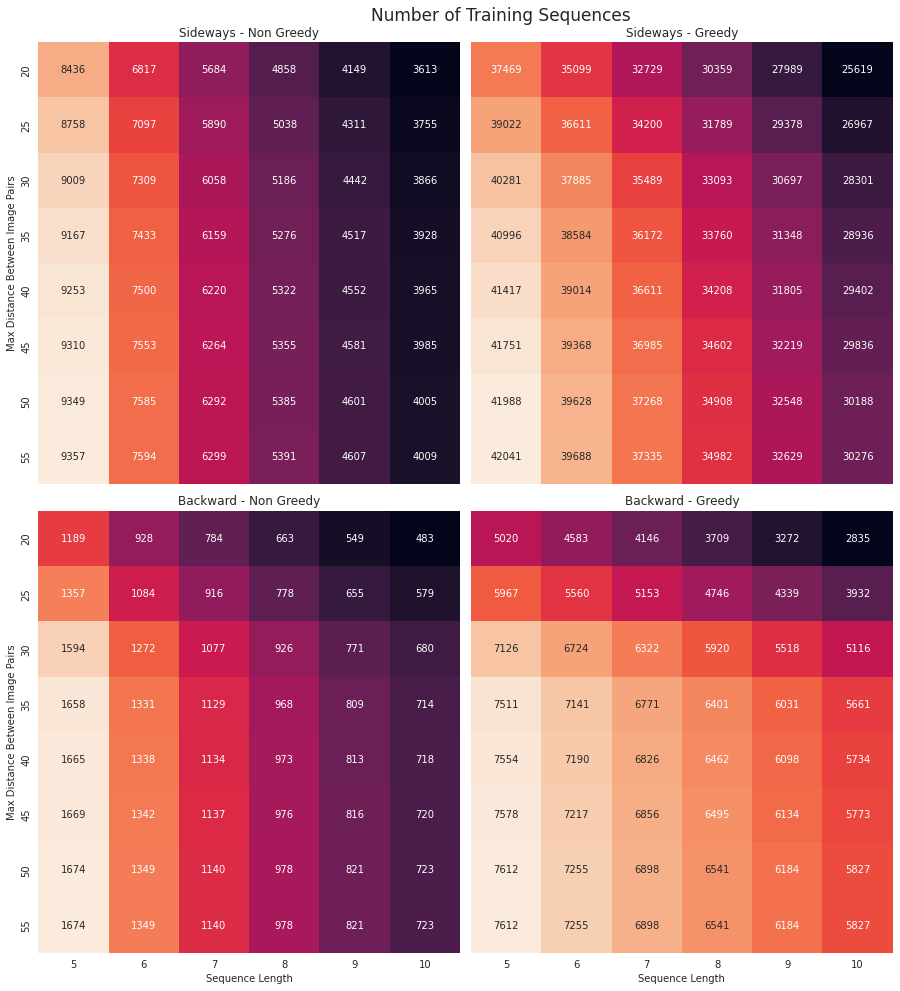

In [22]:
sideways_clean = []
sideways_greedy = []
back_clean = []
back_greedy = []

for max_distance in [20,25,30,35,40,45,50,55]:

   cut = for_plot[max_distance]
   sideways_clean.append(get_num_train(cut,range(5,11)))
   sideways_greedy.append(get_num_train(cut,range(5,11),dirty=True))
   back_greedy.append(get_num_train(cut,range(5,11),kind= "Backward",dirty=True))
   back_clean.append(get_num_train(cut,range(5,11),kind= "Backward",dirty=False))


sideways_clean, sideways_greedy, back_clean, back_greedy = map(np.array,[sideways_clean, sideways_greedy, back_clean, back_greedy])


from matplotlib.colors import LogNorm

fig, axn = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(14,14))
#cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, (ax,data,title) in enumerate(zip(axn.flat,[sideways_clean, sideways_greedy, back_clean, back_greedy],["Sideways - Non Greedy","Sideways - Greedy","Backward - Non Greedy","Backward - Greedy"])):
    sns.heatmap(data, ax=ax, xticklabels=range(5,11), yticklabels=[20,25,30,35,40,45,50,55], 
                cbar=False,
                annot=True, fmt='g')
    ax.set_title(title)

axn[1,0].set_xlabel("Sequence Length")
axn[1,1].set_xlabel("Sequence Length")

axn[0,0].set_ylabel("Max Distance Between Image Pairs")
axn[1,0].set_ylabel("Max Distance Between Image Pairs")

plt.suptitle("Number of Training Sequences",fontsize = 17)
fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig("Training_Size_Distribution.jpg",dpi = 1000)
plt.show()

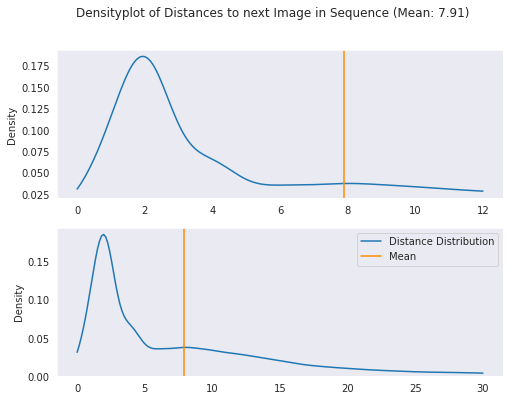

In [23]:
all_distances = np.concatenate(distances["distances"].dropna().values)
fig = plt.figure(figsize=(8,6))
fig.add_subplot(211)
sns.kdeplot(all_distances,clip=[0,12])
plt.axvline(x=all_distances.mean(),color="darkorange",label='Mean')
fig.add_subplot(212)
sns.kdeplot(all_distances,clip=[0,30],label="Distance Distribution")
plt.axvline(x=all_distances.mean(),color="darkorange",label='Mean')
plt.legend()
plt.suptitle(f"Densityplot of Distances to next Image in Sequence (Mean: {all_distances.mean():.2f})")
plt.show()

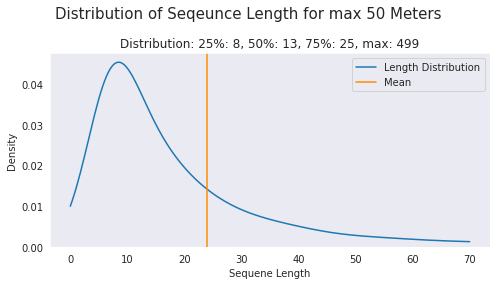

In [25]:
distances = pd.read_feather("max_distance_of_50.feather")
vals = distances["keys"].apply(len)
plt.figure(figsize = (7,4))
sns.kdeplot(vals,clip=[0,70],label="Length Distribution")
plt.axvline(x=vals.mean(),color="darkorange",label='Mean')
plt.xlabel("Sequene Length")
plt.legend()
text = vals.describe()[4:]
text = "Distribution: " + ", ".join([f"{i[0]}: {int(i[1])}"  for i in zip(text.index,text.values)])
plt.title(text)
plt.suptitle("Distribution of Seqeunce Length for max 50 Meters", fontsize = 15)
plt.tight_layout()
plt.savefig("Seq_Len_Distribution_Max_50.jpg",dpi = 800)
plt.show()